In [6]:
# Denoising Diffusion Probabilistic Models, CIFAR-10 dataset

import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import math
import numpy as np

# we already built out the UNet in the previous notebook
# so we import it from the src folder
from src.unet import UNet
from src.ddpm import train_model, validate_model
from src.utils import show_torch_image

ImportError: cannot import name 'plot_loss' from 'src.utils' (/Users/apandya/computer_vision/src/utils.py)

In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define the transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
cifar10_full = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Split the dataset into train and validation sets
train_size = int(0.8 * len(cifar10_full))
val_size = len(cifar10_full) - train_size
train_dataset, val_dataset = random_split(cifar10_full, [train_size, val_size])

# Create DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")


100%|██████████| 170498071/170498071 [00:26<00:00, 6471103.38it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Train dataset size: 40000
Validation dataset size: 10000
Number of training batches: 313
Number of validation batches: 79


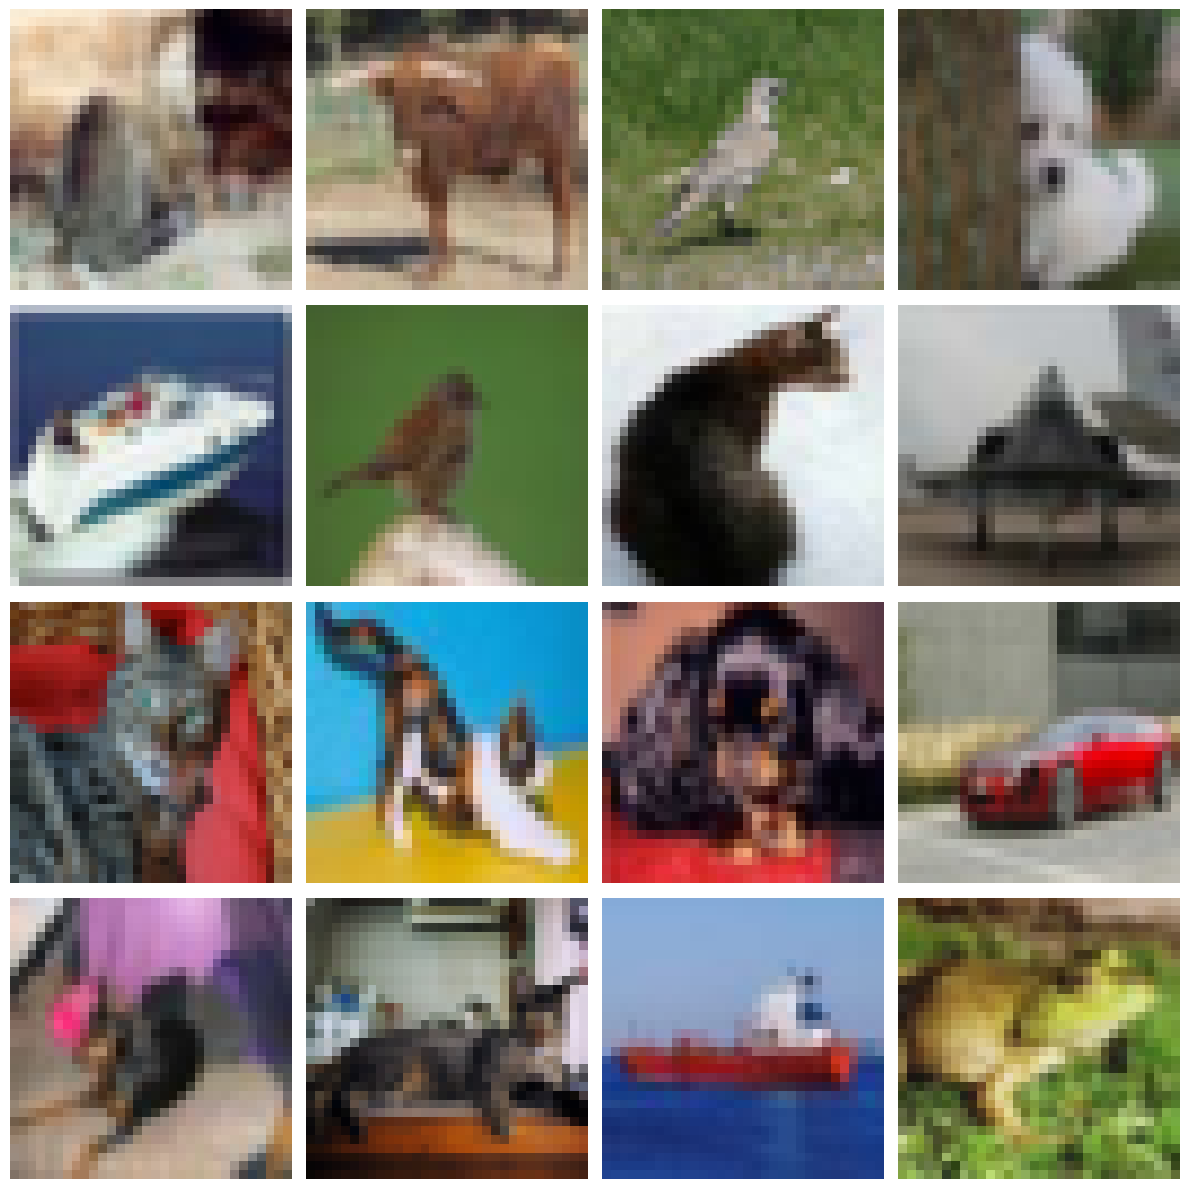

In [8]:
def show_image_grid(dataset, num_images=16, rows=4, cols=4):
    """
    Display a grid of images from a PyTorch dataset.
    
    Args:
        dataset: PyTorch dataset
        num_images: Total number of images to display (default: 16)
        rows: Number of rows in the grid (default: 4)
        cols: Number of columns in the grid (default: 4)
    """
    assert num_images <= len(dataset), "num_images should not exceed dataset size"
    assert rows * cols == num_images, "rows * cols should equal num_images"
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    
    for i in range(num_images):
        img, _ = dataset[i]
        row = i // cols
        col = i % cols
        
        # Denormalize and convert to numpy array
        img = img * 0.5 + 0.5  # Denormalize
        img = img.permute(1, 2, 0).numpy()  # Change from (C,H,W) to (H,W,C)
        
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
show_image_grid(train_dataset)


In [ ]:
model = 